# Notebook 01 - Antônio Esteves - Avaliação de Cientista de Dados

O desafio envolve analisar campanhas de marketing de uma institiução bancária. Nas campanhas é vendido ao cliente um produto adicional de débito automático. Queremos saber se um determinado cliente se inscreve ou não ao produto.

O conjunto de dados não foi separado em treino e validação. No entanto, foi separada uma amostra aleatória com 10% do volume total dos dados. Esta amostra é o conjunto de teste e será usado para avaliação das entregas.

Disclaimer: Este conjunto de dados está disponível publicamente para pesquisa. Como não se trata de um artigo acadêmico, a citação será feita pela referência sugerida pela política de citação do centro de pesquisa: [Dua, D. and Graff, C. (2019). UCI Machine Learning Repository](http://archive.ics.uci.edu/ml).

In [19]:
from scipy import stats
import scipy.stats as sct
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
color = sns.color_palette()

from IPython.core.pylabtools import figsize

# %matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Carregando Dados

Depois de importar algumas bibliotecas necessárias à nossa análise, vamos iniciar carregaando nossos dados. Temos mais de uma milhão de dados, então para essa análise vamos carregar uma amostra aleatória dos nossos dados.

In [132]:
data = pd.read_csv(r'../data/campaigns.csv', sep=',').drop(['Unnamed: 0'], axis=1)
data.shape

(40690, 17)

## Sobre o Conjunto de Dados

Antes de tudo vamos conhecer os nossos dados estruturalmente.

In [133]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40690 entries, 0 to 40689
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40690 non-null  int64 
 1   job        40690 non-null  object
 2   marital    40690 non-null  object
 3   education  40690 non-null  object
 4   default    40690 non-null  object
 5   balance    40690 non-null  int64 
 6   housing    40690 non-null  object
 7   loan       40690 non-null  object
 8   contact    40690 non-null  object
 9   day        40690 non-null  int64 
 10  month      40690 non-null  object
 11  duration   40690 non-null  int64 
 12  campaign   40690 non-null  int64 
 13  pdays      40690 non-null  int64 
 14  previous   40690 non-null  int64 
 15  poutcome   40690 non-null  object
 16  y          40690 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.3+ MB


Cada linha no conjunto de dados representa um cliente, ao todo nossa amostra contem **40690** registros de clientes, entre os quais temos a idade do cliente, ocupação, escolaridade e campanhas. Além disso temos alguns dados pertinentes aos clientes, tal qual ultimo contato com aquele cliente, se ele possui hipoteca ou se ele possui empréstimo.


- **age:** Idade do cliente
- **job:** Ocupação
- **marital:** Estado civil
- **education:** Escolaridade
- **default:** Se o cliente está em dias com as suas obrigações financeiras
- **balance:** Saldo anual em euros
- **housing:** Se o cliente possui hipoteca
- **loan:** Se o cliente possui algum empréstimo pessoal
- **contact:** Meio de contato com o cliente
- **day:** ultimo dia de contato com o cliente
- **month:** Ultimo mês de contato com o cliente
- **duration:** Duração do último contato em segundos
- **campaign:** número de contatos realizados durante esta campanha e para este cliente
- **pdays:** número de dias que passaram após o último contato do cliente de uma campanha anterior
- **previous:** número de contatos realizados antes desta campanha e para este cliente
- **poutcome:** resultado da campanha de marketing anterior 
- **y:** Se o cliente assinou um produto ou não


**Nota:** Um *default*, em finanças, é o incumprimento das obrigações legais ou condições de um empréstimo,[[1]](https://pt.wikipedia.org/wiki/Default_(finan%C3%A7as))

In [134]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [135]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

# Análise

In [175]:
df = data.copy()

df['duration'] = (df['duration']/60)

Vamos avaliar incialmente a interção com os clientes e verificar o quantitativo de contatos efetuado com clientes durante uma capanha.

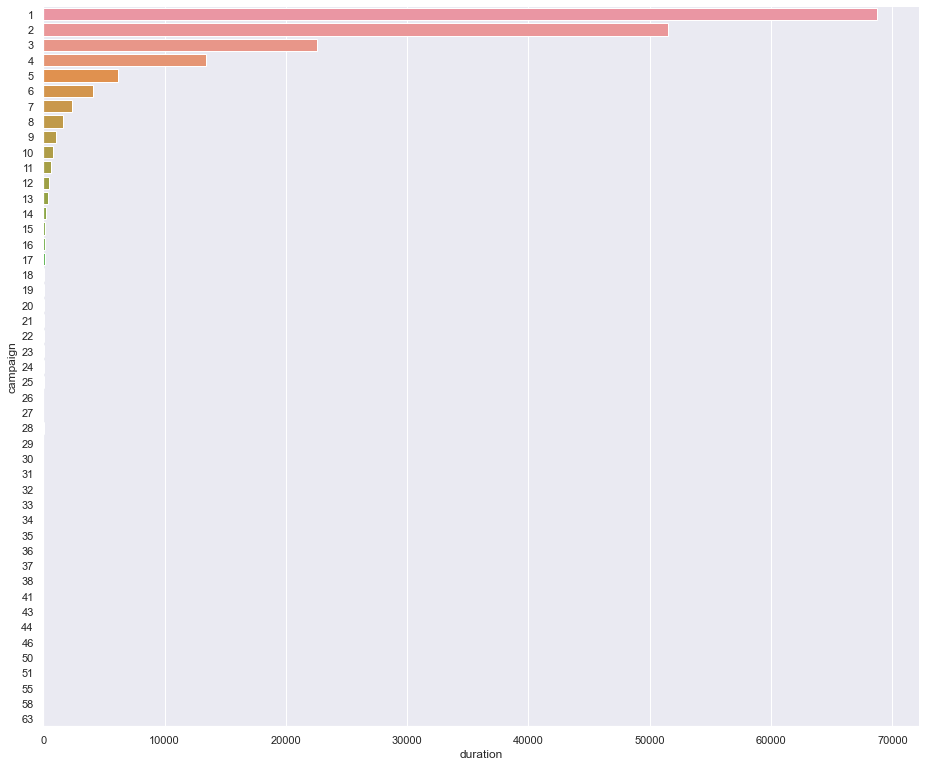

In [176]:
cp_dur = df.groupby(['campaign'])['duration'].sum().reset_index()
cp_dur = cp_dur.sort_values(by='duration', ascending=False)
sns.catplot(x="duration", y='campaign', kind="bar", orient="h", data=cp_dur.sort_values(by='duration'));
fig = plt.gcf()
fig.set_size_inches(15,12)

Como é possível observar acima a grande parte dos clientes recebeu apenas um único contato. Vamos nos concentrar em analizar aqueles clientes que receberam até 10 contatos.

In [147]:
df.sort_values(by='duration', ascending=False)[:10]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
21762,59,technician,married,tertiary,no,6573,yes,no,telephone,10,nov,81.966667,1,-1,0,unknown,no
8979,59,management,married,secondary,no,1321,no,no,unknown,9,jun,64.683333,3,-1,0,unknown,yes
40138,45,services,single,secondary,no,955,no,no,unknown,27,aug,63.083333,1,-1,0,unknown,no
2143,45,blue-collar,married,secondary,no,66,yes,no,unknown,13,may,56.100000,3,-1,0,unknown,no
19045,43,self-employed,married,tertiary,no,423,no,no,cellular,14,aug,55.366667,2,-1,0,unknown,no
21714,30,admin.,married,secondary,no,1310,no,no,telephone,27,oct,54.733333,1,-1,0,unknown,no
21667,36,self-employed,single,tertiary,no,-103,yes,yes,telephone,17,oct,54.216667,1,-1,0,unknown,yes
11163,28,admin.,single,secondary,no,-7,no,yes,unknown,26,jun,53.050000,2,-1,0,unknown,yes
5812,44,services,divorced,secondary,no,51,yes,yes,unknown,27,may,51.566667,2,-1,0,unknown,yes
3935,34,blue-collar,married,primary,no,183,yes,no,unknown,19,may,51.300000,4,-1,0,unknown,no


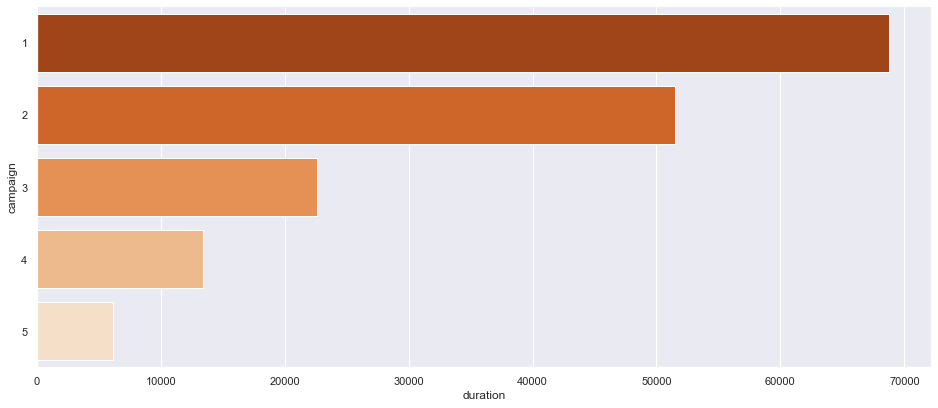

In [179]:
cp_dur = cp_dur.sort_values(by='duration', ascending=False)[:5]
sns.catplot(x="duration", y='campaign', kind="bar", orient="h", data=cp_dur, palette="Oranges_r");
fig = plt.gcf()
fig.set_size_inches(15,6);

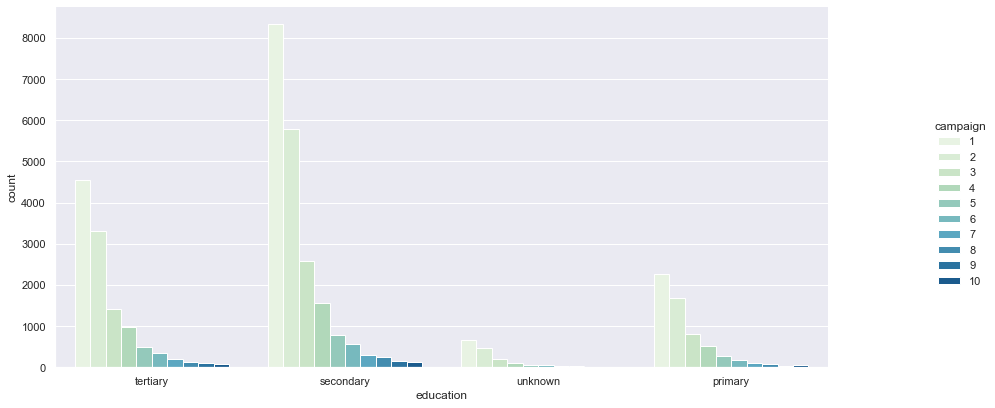

In [27]:
cp_edu = data[data['campaign'] <= 10]
sns.catplot(x="education", hue="campaign", kind="count", data=cp_edu, palette='GnBu');
fig = plt.gcf()
fig.set_size_inches(15,6);

Aqui é possível observar que os clientes que receberam um contato são maioria no nível escolar de **educação secundária**. Uma parcela considerável também encontra-se naqueles que que possuem **nível superior**

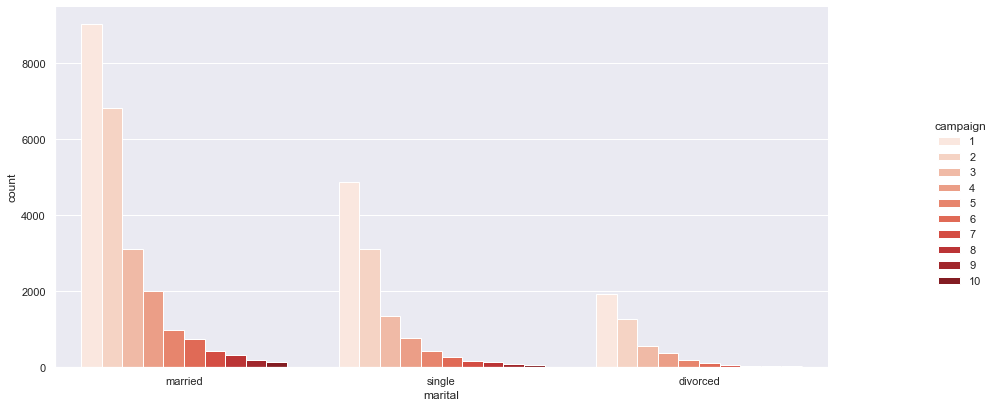

In [28]:
cp_edu = data[data['campaign'] <= 10]
sns.catplot(x="marital", hue="campaign", kind="count", data=cp_edu, palette='Reds');
fig = plt.gcf()
fig.set_size_inches(15,6);

Cliente que são casados também estão entre os que receberam um único contato por campanha, seguido pelos solteiros. Vamos ver agora como os clientes se distribuem quanto a sua ocupação.

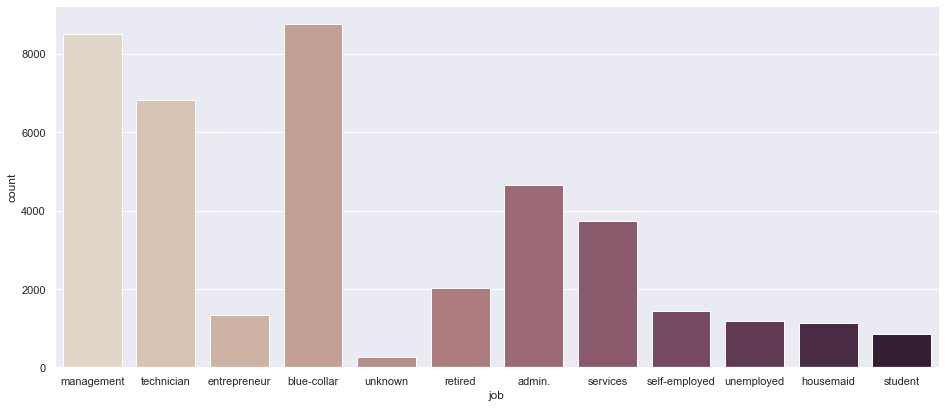

In [145]:
sns.catplot(x="job", kind="count", palette="ch:.25", data=data)
fig = plt.gcf()
fig.set_size_inches(15,6);

Os clientes estão presentes em 12 categorias de ocupações, dentre as quais estão mais presentes clientes com ocupações de **gerência**, **técnicos**, e membros da **classe trabalhadora** (em geral trabalhadores de chão de fábrica). Uma menor parcela é representada por ocupações em cargos de **administração**, **seviços** e também **aposentados**.

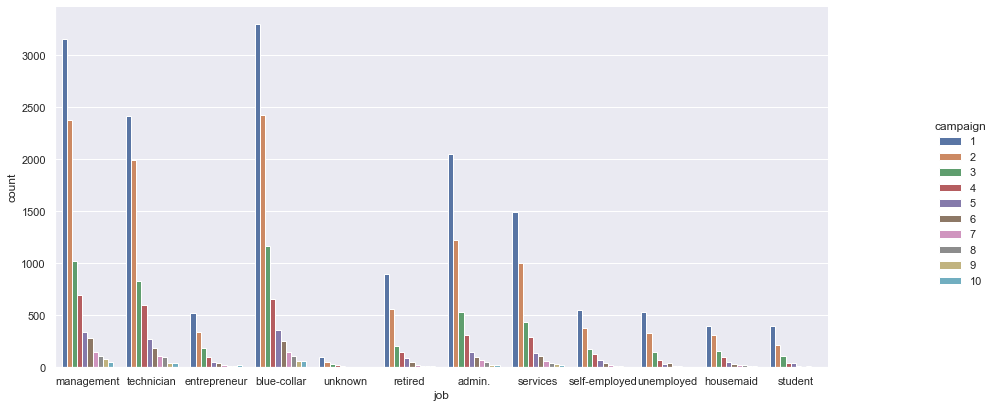

In [30]:
cp_job = data[data['campaign'] <= 10]
sns.catplot(x="job", hue="campaign", kind="count", data=cp_edu);
fig = plt.gcf()
fig.set_size_inches(15,6);

Sem surpresa as classes de ocupações mais dominantes tenden a ser o alvo dos contatos. Outras classes de ocupações aparentam não ser o alvo das campanhas como ocupações de menor poder aquisitivo. Estão entre elas: **estudantes**, **empregadas domésticas** e **empregados autônomos** e **desempregados**.

Vamos avaliar os clientes sob uma ótica mais especifica para cada cliente, enfatizando detalhes como empréstimos, hipoteca e capacidade de honrar compromissos financeiros.

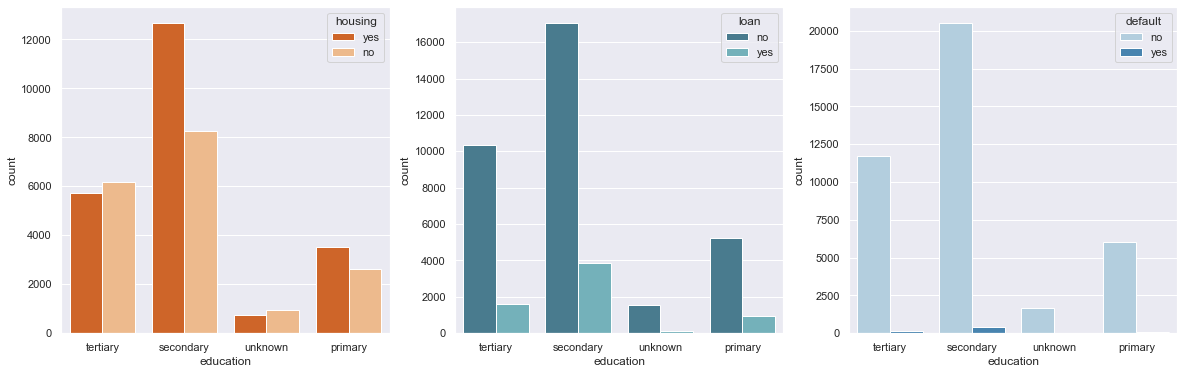

In [32]:
fig, ax =plt.subplots(1,3,squeeze=False)
ax = ax.flatten()
sns.countplot(x="education",  hue='housing', palette="Oranges_r", data=data, ax=ax[0])
sns.countplot(x="education",  hue='loan', palette="GnBu_d", data=data, ax=ax[1]);
sns.countplot(x="education",  hue='default', palette="Blues", data=data, ax=ax[2]);
fig = plt.gcf()
fig.set_size_inches(20,6);

Vamos avaliar agora sob a perspectiva do estado civíl dos clientes como estão distribuidos os clientes que possuem **empréstimo**, **hipoteca** e honram com seus compromissos financeiros.

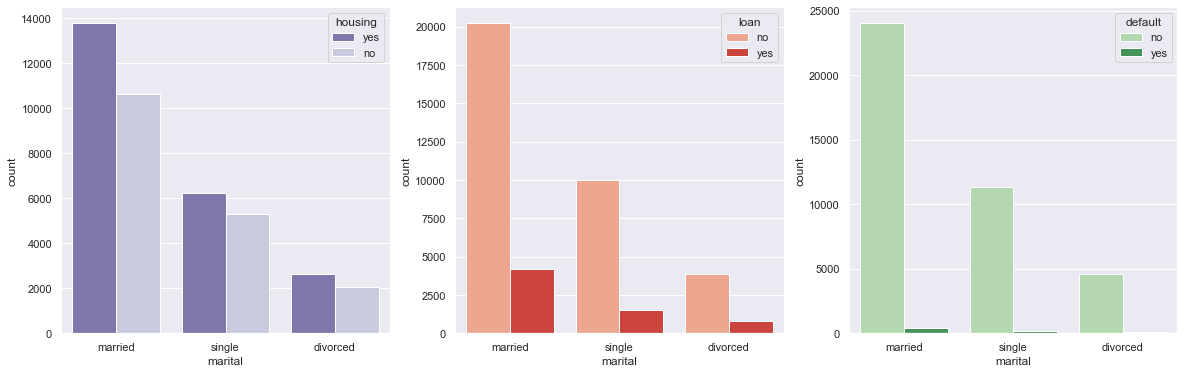

In [33]:
fig, ax =plt.subplots(1,3,squeeze=False)
ax = ax.flatten()
sns.countplot(x="marital",  hue='housing', palette="Purples_r", data=data, ax=ax[0])
sns.countplot(x="marital",  hue='loan', palette="Reds", data=data, ax=ax[1]);
sns.countplot(x="marital",  hue='default', palette="Greens", data=data, ax=ax[2]);
fig = plt.gcf()
fig.set_size_inches(20,6);

Apesar de a grande maioria dos clientes terem hipotecas e empréstimos ativos, sua capacidade em honrar compromissos também é alta. Partindo disso, vamos ver como estão dispostas as finanças de cada cliente, categorizando por **escolaridade** e **estado civil**.

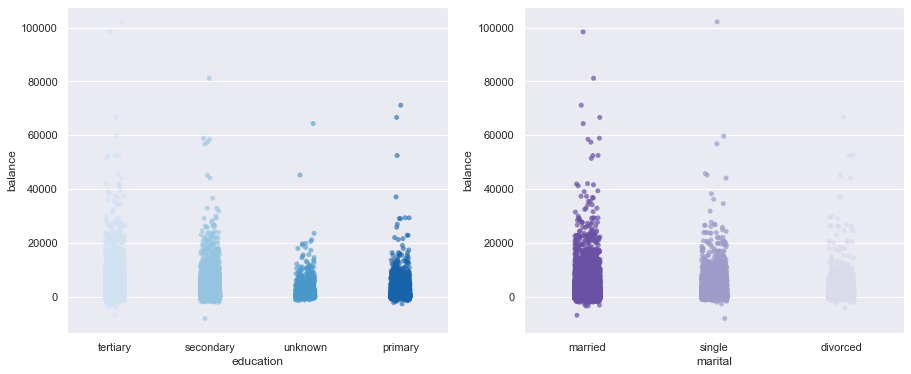

In [34]:
fig = plt.figure()

ax1 = fig.add_subplot(121)
g = sns.stripplot(x="education", y="balance", data=data, palette="Blues", alpha=.6, ax=ax1);

ax2 = fig.add_subplot(122)
sns.stripplot(x="marital", y="balance", data=data, palette="Purples_r", alpha=.7, ax=ax2);

fig = plt.gcf()
fig.set_size_inches(15,6)

Apesar das distribuições apresentadas serem bem distribuidas, apresentam algumas peculiaaridades. Os clientes com renda mais expressiva no quesito escolaridade possuem nível superior e educação secundária. Já quanto ao estado civil, os clientes que possuem um melhor saldo são os casados. Podemos definir nesse momento 4 grupos expressivos baseando-se no saldo dos clientes:

 - Clientes com nível superios e casados.
 - Clientes com nível superior e solteiros.
 - Clientes com educação secundária e casados.
 - Clientes com educação secundária e solteiros.
 
 A seguir vamos avaliar como sob a mesma perspsctiva do saldo os clientes se agrupam por acupação.

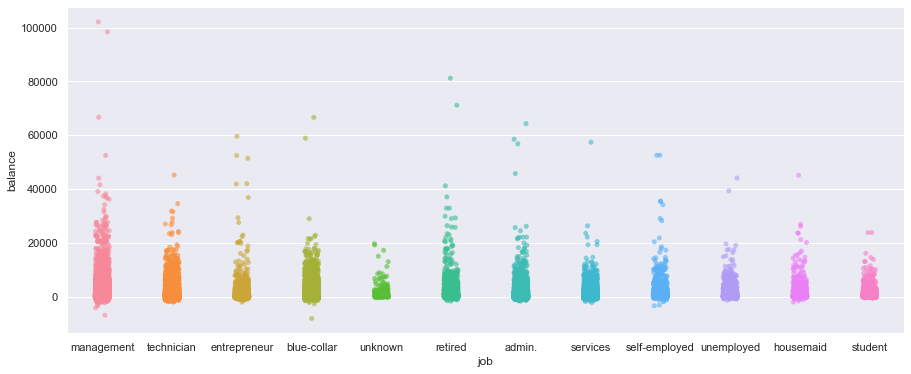

In [35]:
fig = plt.figure()
g = sns.stripplot(x="job", y="balance", data=data,  alpha=.6);
fig = plt.gcf()
fig.set_size_inches(15,6)

Cliente com ocupações de **gerência, **aposentados** e **trabalhadores** que atuam na indústria possuem um saldo mais expressivo, ultrapasando inclusive empresários. Entre outros grupos que também se apresentam como significativos estão as ocupações em cargos **administrativos** e de **serviços**, além dos **técnicos**.

Vamos agora avaliar número de dias que passaram após o último contato do cliente de uma campanha anterior juntamente com os resultados das campanhas de marketing anteriores e entender qual o impacto nos clientes.

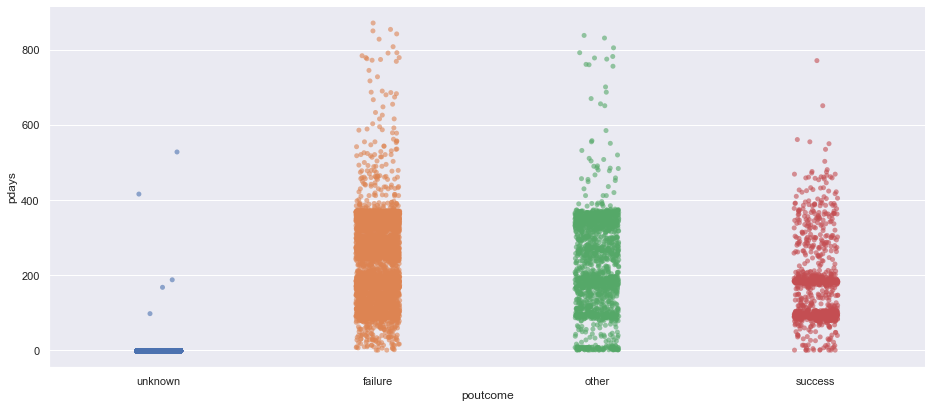

In [39]:
cp_edu = data
sns.catplot(x="poutcome", y='pdays', data=cp_edu, alpha=.6);
fig = plt.gcf()
fig.set_size_inches(15,6)

Ao observarmos o sucesso ou fracasso de campanhas anteriores e considerarmos o sucesso ou fracasso dela, juntamente com a quantidade de dias passados desde a última vez que o cliente foi contactado um detalhe que chama a atenção. Quando a campanha passada foi falha para aquele cliente o total de dias para retomar o contato é maior.

Vamos ver em quais meses esse último contato foi mais frequente a seguir:

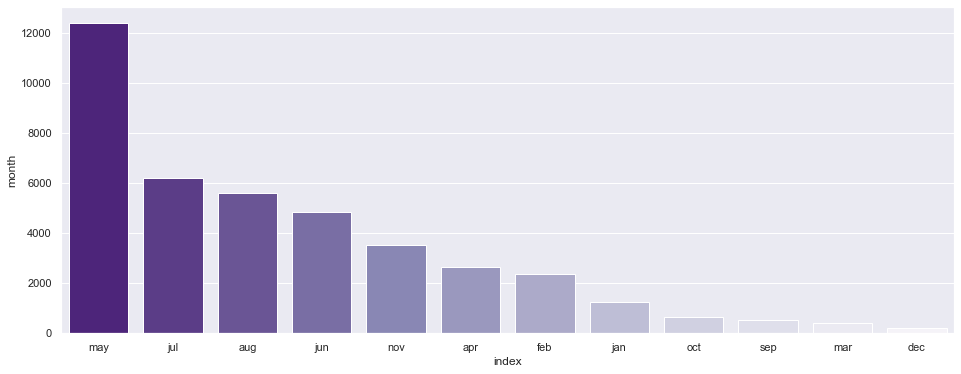

In [299]:
df_month = pd.DataFrame(data['month'].value_counts().reset_index())
fig = sns.barplot(x=df['index'], y=df['month'],  palette='Purples_r')
fig = plt.gcf()
fig.set_size_inches(16,6);

Aparentemente **Maio** é um mês onde há muitos contatos efetuados pela útima vez, seguidos por **Julho** e **Agosto**, provavelmente pelo dia das mães e dos pais. É possível observar ainda que o mês é muito intenso diante desses contatos, apresentando uma queda significativa após o dia **20**.

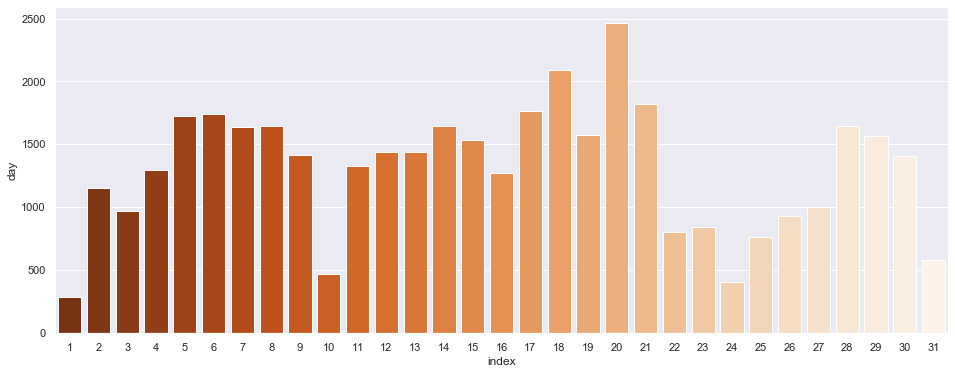

In [338]:
df_day = pd.DataFrame(data['day'].value_counts().reset_index().sort_values(by='index', ascending=True))
fig = sns.barplot(x=df_day['index'], y=df_day['day'],  palette='Oranges_r')
fig = plt.gcf()
fig.set_size_inches(16,6);

In [311]:
data['age'].min(), data['age'].max()

(18, 95)

Vamos agora verificar como está distribuida a faixa etária dos clientes.

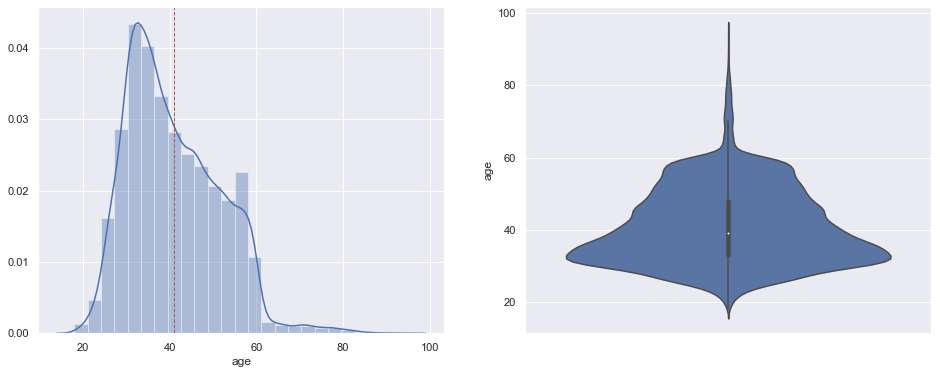

In [332]:
fig, ax =plt.subplots(1,2)
sns.distplot(data['age'], bins=25, ax=ax[0])
ax[0].axvline(data['age'].mean(), color='r', linestyle='dashed', linewidth=1)
sns.violinplot(y=data["age"], hue=data["loan"], ax=ax[1])
fig = plt.gcf()
fig.set_size_inches(16,6);

É possível observar que a distribuição das faixas etárias é enviesada a direita, além disso a distribuição informa que as idades mais frequentes dos clientes estão entre **20** e **40** anos, o que também é ratificado pelo gráfico de densidade (direita).

A seguir vamos categorizar nosas idades e apresentar o quantitativo agrupado por intervalos como uma forma de segmentar nossos clientes.

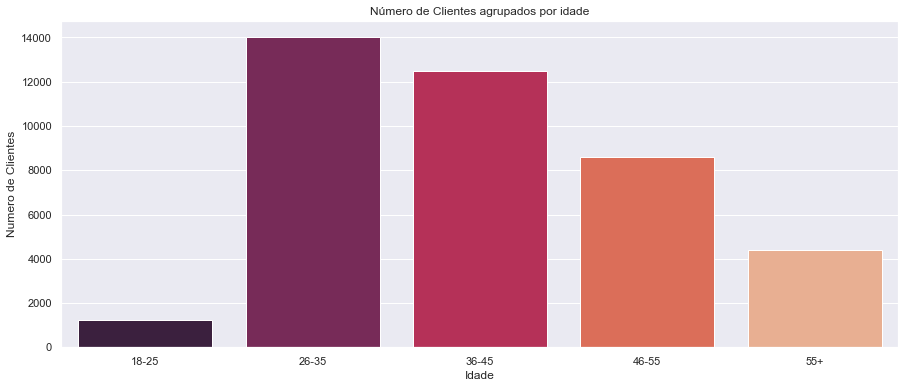

In [40]:
age18_25 = data['age'][(data['age'] <= 25) & (data['age'] >= 18)]
age26_35 = data['age'][(data['age'] <= 35) & (data['age'] >= 26)]
age36_45 = data['age'][(data['age'] <= 45) & (data['age'] >= 36)]
age46_55 = data['age'][(data['age'] <= 55) & (data['age'] >= 46)]
age55above = data['age'][data['age'] >= 56]

x = ["18-25","26-35","36-45","46-55","55+"]
y = [len(age18_25.values),len(age26_35.values),len(age36_45.values),len(age46_55.values),len(age55above.values)]

plt.figure(figsize=(15,6))
sns.barplot(x=x, y=y, palette="rocket")
plt.title("Número de Clientes agrupados por idade")
plt.xlabel("Idade")
plt.ylabel("Numero de Clientes")
plt.show()

Nessa "nova" estratégia de exibição das faixas etárias, visivelmente, a faixa etária de **26** a **35** é superior a todas as outras faixas etárias, seguinda pelos clientes com idades entre **36** e **45**.

Através do gráfico da distribuição dos pesos é possível observar a distribuição possui uma cauda mais longa à direita, indicando a ocorrência de valores altos com baixa frequência. Esse tipo de distribuição é denominada assimétrica positiva ou à direita. Para enfatizar nossa assertiva, vamos efetuar uma teste de normalidade.

($H_0$) : Sugere que a distribuição do saldo médio dos clientes segue uma ditribuição normal

($H1$) : Sugere que a distribuição do saldo médio dos clientes **NÃO** segue uma ditribuição normal

 - Valor $\textit{p}$ > 0,05 : falha ao rejeitar a hipótese nula ($H_0$)
 - Valor de $\textit{p}$ <= 0,05 : Rejeita a hipótese nula ($H_0$)

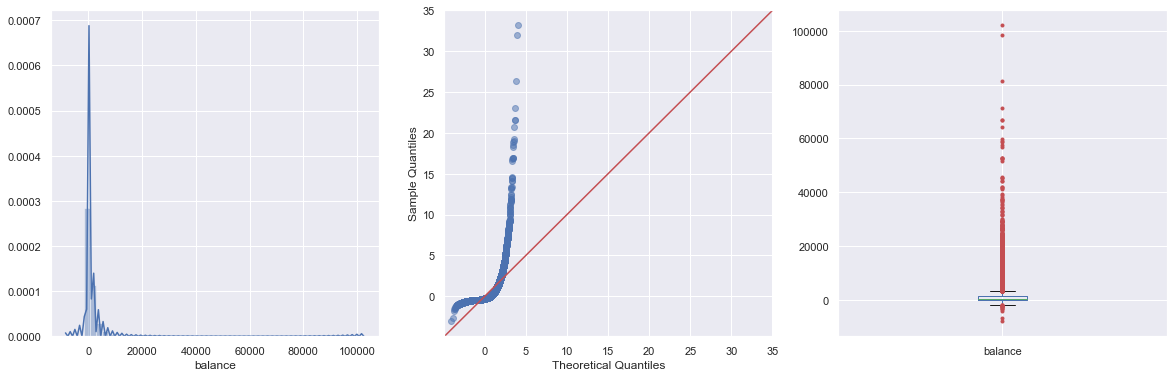

In [378]:
fig, ax =plt.subplots(1,3)
sns.distplot(data['balance'], bins= 50, hist_kws={'density':True}, ax=ax[0]);
sm.qqplot(data['balance'], fit=True, line='45', alpha=.5, ax=ax[1]);
data['balance'].plot(kind='box', sym='r.', ax=ax[2]);
fig = plt.gcf()
fig.set_size_inches(20,6);

In [373]:
alpha = 0.05
stats, p_value = sct.normaltest(data['balance'])
if p_value > alpha:
    print('p-valor: {}'.format(p_value))
    print('A série é Gaussiana (falha ao rejeitar H0)')
else:
    print('p-valor: {}'.format(p_value))
    print('A série não é Gaussiana (rejeitamos H0)')

p-valor: 0.0
A série não é Gaussiana (rejeitamos H0)


Podemos ver que nosso nível descritivo estatístico não supera o valor de **alpha** a **5%** logo, podemos **rejeitar a hipótese nula** com um nível de significância inferior a **5%** (ou seja, uma baixa probabilidade de que o resultado seja um acaso estatístico). 

Concluimos então que a distribuição do saldo médio dos clientes ao ano não segue uma distribuição normal. Também podemos verificar isso rapidamente observando um histograma de nossas observações juntamente com o QQ plot (Centro).

O boxplot (direita) ratifica que a distribuição é assimétrica. Há uma alta concentração de dados nos valores mais baixos. A cauda mais longa da distribuição fica à direita, indicando a ocorrência de valores altos com baixa frequência destacados em vermelho, denotaendo uma distribuição assimétrica ou não normal.